### **Objectives**

In this assignment, the goal is to fine-tune the pre-trained YOLOv7 model on a custom
dataset. After finishing this assignment, you will be familiar with the concept of Object
Detection/Recognition in a Transfer Learning framework which enables you to fine-tune
large-scale models on simpler downstream tasks.

### **Problem Statement**


Safety of the workers is one of the most important things in working areas. Especially for the people working in the construction zones, it becomes even more crucial.
Companies and workers will suffer from the huge costs caused by not wearing the Personal Protection Equipment (PPE) while working in these areas. Therefore, real-time
surveillance of the construction areas is necessary in order to make sure everybody is safe. 
In this assignment, we focus on the safety helmet which is one of the most
important PPEs.
YOLOv7 is one of the fastest and most accurate object detection models used widely in
real-time applications. 
The output of YOLOv7 for an example image is shown below:

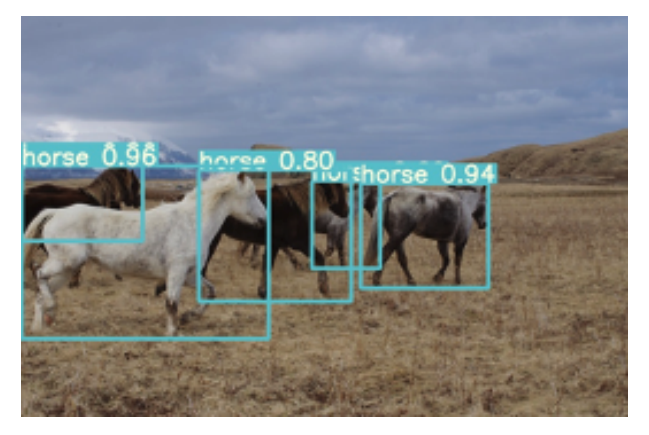

However, the original model is not trained to detect the personal protection equipment or if a person is wearing them or not. In this assignment, you will train YOLOv7 in a transfer learning framework in order to detect the safety helmets of the workers and determine if they are wearing them or not in the construction zones.

## Setup

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b1a3c8c251b7ed2df668429ef2c88cf45407d1d64d7426b06f01e30396784ade
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
# if the openCV version is < 4.4.0 update to the latest otherwise skip this step
!pip install opencv-python==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51.0 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66


In [ ]:
# import the relevant libraries
import numpy as np
import cv2 # openCV
import wget

In [ ]:
# check the opencv version
print(cv2.__version__)

4.5.2


In [ ]:
# import the cv2_imshow as a replacement of cv2.imshow to prevent errors
from google.colab.patches import cv2_imshow


In [ ]:
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from numpy import random

from models.experimental import attempt_load
from utils.Ndatasets import LoadStreams, LoadImages , letterbox
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box , plot_Label
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

# Part-I: Install and Examine the YOLOv7

In [ ]:
!git clone https://github.com/Walid-Ahmed/PPE-YOLOV7.git

In [ ]:
%cd PPE-YOLOV7
!pip install -r requirements.txt

In [ ]:
def detect(save_img=False):
    source, weights, view_img, save_txt, imgsz, trace = opt.source, opt.weights, opt.view_img, opt.save_txt, opt.img_size, not opt.no_trace
    save_img = not opt.nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt.device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size

    if trace:
        model = TracedModel(model, device, opt.img_size)

    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    old_img_w = old_img_h = imgsz
    old_img_b = 1

    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Warmup
        if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
            old_img_b = img.shape[0]
            old_img_h = img.shape[2]
            old_img_w = img.shape[3]
            for i in range(3):
                model(img, augment=opt.augment)[0]

        # Inference
        t1 = time_synchronized()
        with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
            pred = model(img, augment=opt.augment)[0]
        t2 = time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t3 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]} {conf:.2f}'
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)

            # Print time (inference + NMS)
            print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                    print(f" The image with the result is saved in: {save_path}")
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        #print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')

In [ ]:
Command = ' --weights yolov7.pt --conf 0.3 --class 0 --source Test.jpg'

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default='yolov7.pt', help='model.pt path(s)')
    parser.add_argument('--source', type=str, default='inference/images', help='source')  # file/folder, 0 for webcam
    parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
    parser.add_argument('--conf-thres', type=float, default=0.25, help='object confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='IOU threshold for NMS')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='display results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default='runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--no-trace', action='store_true', help='don`t trace model')
    opt = parser.parse_args(Command.split())
    print(opt)
    #check_requirements(exclude=('pycocotools', 'thop'))

    with torch.no_grad():
        if opt.update:  # update all models (to fix SourceChangeWarning)
            for opt.weights in ['yolov7.pt']:
                detect()
                strip_optimizer(opt.weights)
        else:
            detect()

Namespace(agnostic_nms=False, augment=False, classes=[0], conf_thres=0.3, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='Test.jpg', update=False, view_img=False, weights=['yolov7.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

3 persons, Done. (1704.4ms) Inference, (1.1ms) NMS
 The image with the result is saved in: runs/detect/exp2/Test.jpg
Done. (1.730s)


# Part-II: Data Preparation

**Download Data**

**Trasnform** **From** **Pascal** **to** **YOLOV7** **Format** 


**Split** Data into ( Train 80% , Valid 15% , Test 5% ) 

Example For Yolov7 Fromat and Folders should be as shown in PDF.

You'll need to create a yaml file for the data , yaml file example below.

# Part-III: Transfer Learning 
Build a YOLO7 model to detect Helemets 





In [ ]:
!python train.py --batch 12 --epochs 10 --data PPE-train-4/data.yaml --weights yolov7_training.pt --device 0 

# Part-IV: Deploy the Helemets detction Model using a cascade pipeline

In [52]:
from utils.datasets import LoadStreams, LoadImages , letterbox

In [53]:
Green = (0, 255, 0)
Red = (0, 0, 255)
Black = (0,0,0)
White = (255,255,255)

In [54]:
def detect(save_img=False):

    source, weights,weights2, view_img, save_txt, imgsz, trace = opt.source, opt.weights,opt.weights2, opt.view_img, opt.save_txt, opt.img_size, not opt.no_trace
    save_img = not opt.nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt.device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    model2 = attempt_load(weights2, map_location=device)  # load FP32 model

    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size



    if trace:
        model = TracedModel(model, device, opt.img_size)
        model2 = TracedModel(model2, device, opt.img_size)

    if half:
        model.half()  # to FP16
        model2.half()

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)


    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    names2 = model2.module.names if hasattr(model2, 'module') else model2.names

    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))
        model2(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model2.parameters())))# run once
    old_img_w = old_img_h = imgsz
    old_img_b = 1

    old_img1_w = old_img1_h = imgsz
    old_img1_b = 1

    t0 = time.time()
    Frame = 0
    for vid,path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Warmup
        if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
            old_img_b = img.shape[0]
            old_img_h = img.shape[2]
            old_img_w = img.shape[3]
            for i in range(3):
                model(img, augment=opt.augment)[0]

        # Inference
        t1 = time_synchronized()
        with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
            pred = model(img, augment=opt.augment)[0]
        t2 = time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t3 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s) #Here

        Helmets = 0
        NoHelmets = 0


        # Process detections

        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):

                    Helmet , NewCords = Pipline()


                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        if Helmet == 1 :
                            label = f'{names[int(cls)]} {conf:.2f} Wearing Helmet'
                            plot_one_box(xyxy, im0, label=label, color=Green, line_thickness=1)
                            label2 = f' Helmet'
                            plot_one_box(NewCords, im0, label=label2, color=Green, line_thickness=1)
                            Helmets = Helmets + 1
                        else:
                            label = f'{names[int(cls)]} {conf:.2f} Not Wearing Helmet'
                            plot_one_box(xyxy, im0, label=label, color=Red, line_thickness=1)
                            NoHelmets = NoHelmets + 1

            # Print time (inference + NMS)
            HelmetsLabel = f'Wearing Helmets {Helmets}'
            plot_Label( 10 , 35 , im0 , Black , HelmetsLabel ,line_thickness=3)
            plot_Label(10, 35, im0, White, HelmetsLabel, line_thickness=2)
            NoHelmetsLabel = f'Not Wearing Helmets {NoHelmets}'
            plot_Label(10, 55, im0, Black, NoHelmetsLabel, line_thickness=3)
            plot_Label(10, 55, im0, White, NoHelmetsLabel, line_thickness=2)
            print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')
            Frame = Frame + 1
            with open(save_path[:-4] + '.txt', 'a') as f:
                f.write(f'Frame {Frame} : Workers {HelmetsLabel} , Workers {NoHelmetsLabel} \n')



            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                    print(f" The image with the result is saved in: {save_path}")
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        #print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')

In [55]:
def Pipline(im0 , xyxy , device ,half , model2 , vid):
    im1 = im0[int(xyxy[1]):int(xyxy[3]), int(xyxy[0]):int(xyxy[2])]

    img1 = letterbox(im1, 640, stride=32)[0]

    # Convert
    img1 = img1[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img1 = np.ascontiguousarray(img1)

    img1 = torch.from_numpy(img1).to(device)
    img1 = img1.half() if half else img1.float()  # uint8 to fp16/32
    img1 /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img1.ndimension() == 3:
        img1 = img1.unsqueeze(0)

    # Warmup
    if device.type != 'cpu' and (
            old_img1_b != img1.shape[0] or old_img1_h != img1.shape[2] or old_img1_w != img1.shape[3]):
        old_img1_b = img1.shape[0]
        old_img1_h = img1.shape[2]
        old_img1_w = img1.shape[3]
        for i in range(3):
            model2(img1, augment=opt.augment)[0]


    t1 = time_synchronized()
    with torch.no_grad():  # Calculating gradients would cause a GPU memory leak
        pred2 = model2(img1, augment=opt.augment)[0]
    t2 = time_synchronized()

    # Apply NMS
    pred2 = non_max_suppression(pred2, opt.conf_thres, opt.iou_thres, classes=opt.objects,agnostic=opt.agnostic_nms)
    t3 = time_synchronized()


    Helmet = 0
    # print(im0.shape)
    # print(im1.shape)
    # print(img.shape)
    # print(img1.shape)
    # Scale = im1.shape[0]/im0.shape[0]
    # print("Scale" ,Scale)
    for i2, det2 in enumerate(pred2):
        NewCords = []
        for *xyxy2, conf2, cls2 in reversed(det2):
            Helmet = 1
            if vid==1: # calculating new cordinates of helmet
                NewCords.append(xyxy[0] + (xyxy2[0]*0.5))
                NewCords.append(xyxy[1] + (xyxy2[1]*0.5))
                NewCords.append(NewCords[0] + ((xyxy2[2]-xyxy2[0])*0.5))
                NewCords.append(NewCords[1] + ((xyxy2[3]-xyxy2[1])*0.5))
            else :
                NewCords.append(xyxy[0] + (xyxy2[0]*0.9))
                NewCords.append(xyxy[1] + (xyxy2[1]*0.9))
                NewCords.append(NewCords[0] + ((xyxy2[2] - xyxy2[0])))
                NewCords.append(NewCords[1] + ((xyxy2[3] - xyxy2[1])))
            break
    return Helmet , NewCords


In [56]:
Command = '--weights yolov7.pt --weights2 Helmet.pt --conf 0.3 --class 0  --object 0  --source Test.jpg'

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--weights', nargs='+', type=str, default='yolov7.pt', help='model.pt path(s)')
parser.add_argument('--weights2', nargs='+', type=str, default='yolov7.pt', help='model.pt path(s)')
parser.add_argument('--source', type=str, default='inference/images', help='source')  # file/folder, 0 for webcam
parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
parser.add_argument('--conf-thres', type=float, default=0.25, help='object confidence threshold')
parser.add_argument('--iou-thres', type=float, default=0.45, help='IOU threshold for NMS')
parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
parser.add_argument('--view-img', action='store_true', help='display results')
parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 0 2 3')
parser.add_argument('--objects', nargs='+', type=int, help='filter by class: --object 0, or --object 0 2 3')
parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
parser.add_argument('--augment', action='store_true', help='augmented inference')
parser.add_argument('--update', action='store_true', help='update all models')
parser.add_argument('--project', default='runs/detect', help='save results to project/name')
parser.add_argument('--name', default='exp', help='save results to project/name')
parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
parser.add_argument('--no-trace', action='store_true', help='don`t trace model')
opt = parser.parse_args(Command.split())
print(opt)
#check_requirements(exclude=('pycocotools', 'thop'))

with torch.no_grad():
    if opt.update:  # update all models (to fix SourceChangeWarning)
        for opt.weights in ['yolov7.pt']:
            detect()
            strip_optimizer(opt.weights)
    else:
        detect()

Namespace(agnostic_nms=False, augment=False, classes=[0], conf_thres=0.3, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, objects=[0], project='runs/detect', save_conf=False, save_txt=False, source='Tests.jpg', update=False, view_img=False, weights=['yolov7.pt'], weights2=['Helmet.pt'])
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 


Notice the image has 2 bounding boxes, the first identifying the person the second
identifying the hardhat within this bounding box, the person identified should have a
bounding box around them either Red if no helmet was detected within the bounding
box area and Green in case there was a helmet within the bounding box area. You are
required to have the same output.The image also has the description of the frame top
left of the image

Test Image


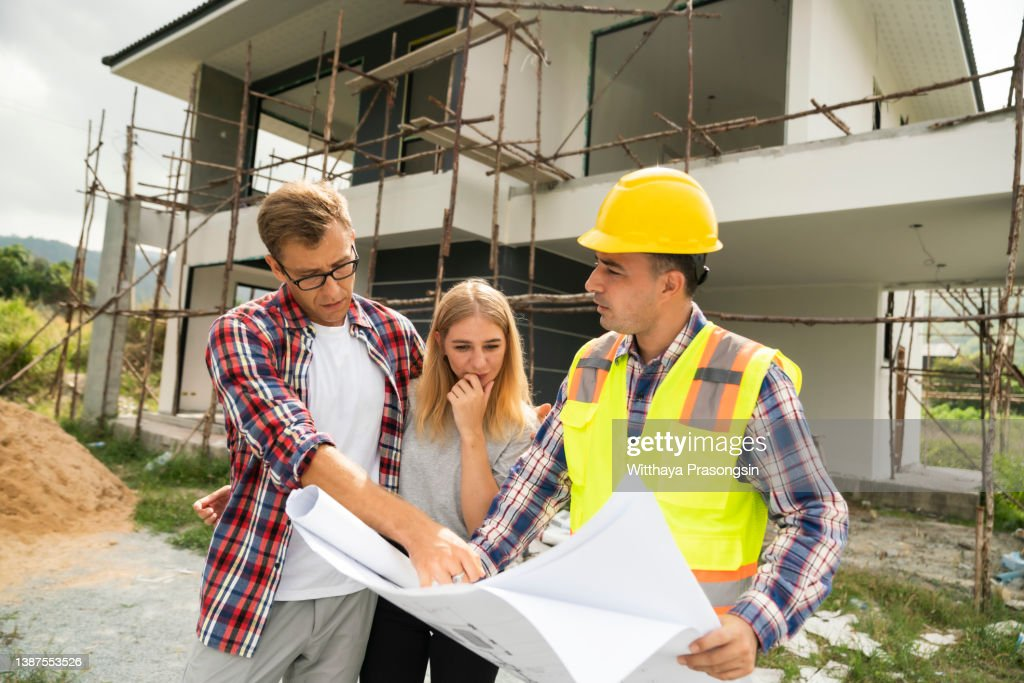

In [ ]:
url="https://raw.githubusercontent.com/Walid-Ahmed/PPE-YOLOV7/main/Test.jpg"
filename = wget.download(url)
testImage = cv2.imread(filename)

cv2_imshow(testImage)

Expected Output

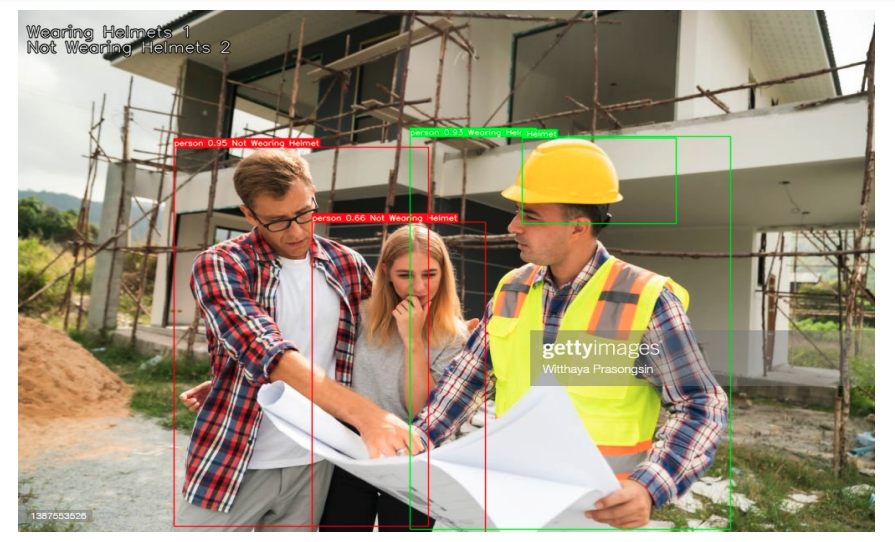